# CIS 545 Project: Amazon Review Analysis and Classification

***Design by: Jialin Lou***

***Date: 12/11/2019***

This notebook includes code for CIS 545 final project. It contains code that predict the star ratings ranging from 1-5 based on the review text content of Amamzon products.

It is a continuation of HW4, where we stopped at a test accuracy of 79.855% with random forest classifer using TF-IDF transformed features after applying PCA. 

**To explore more and improve accuracy, models below are chosen and tested:**


> *1.   Support vector machine that uses one-vs-rest strategy for multi-label classifcation on tf-idf transformed data.*

> *2.   Logisitic regression with selection of regularization strength on tf-idf transformed data.*

> *3.   Multi-layer perceptrons with max_iter of 500 on tf-idf transformed data.*

> *4.   Doc2Vec embeddings on recovered text from review_dict along with logisitic regression.*

> *5.   Simple deep learning using Keras.*



# Install and imports

In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

In [2]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [3]:
# import models and necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors, Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import TaggedDocument

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from datetime import *
from operator import itemgetter

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

Load data into *reviews_dict, reviews_bow, reviews_times,* and *y*





In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

# Helper functions

Helper functions for look up documents in corpus and translate math matrix corpus into readable text content

In [0]:
def lookup_docs(corpus, indices):
  """
  This function returns a list of documents 
  which locate at the positions specified in the indices.
  """
  index_doc = 0
  docs = []
  for doc in corpus:
    if index_doc in indices:
      docs.append(doc)
    index_doc = index_doc+1
  return docs

In [0]:
def translate_review(review, reviews_dict):
  """
  This function returns a list of words 
  that appear in the document.
  """
  words = []
  for index,freq in review:
    for i in range(0,int(freq)):
      words.append(reviews_dict[index])
  return words

# Step 1: Data exploration
Task: convert time into organized and readable timestamps.
Draw two graphs:

1.   the timestamp of each sample
2.   the star rating of each sample

and explore if there is any relationship between *timestamps* and *star ratings*.


In [0]:
def convert_times(reviews_times):
  """
  This function takes in a review time
  and converted to a datetime object.
  Returns a panda series of datetime object.
  """
  time = []
  for review_time in reviews_times:
    time.append(datetime.fromtimestamp(review_time))
  df = pd.Series(time)
  return df

In [0]:
converted_times = convert_times(reviews_times)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


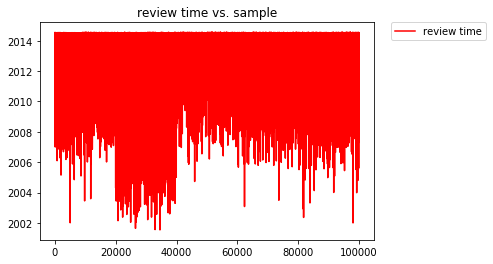

In [10]:
plt.plot(converted_times, 'r', label='review time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('review time vs. sample')
plt.show()

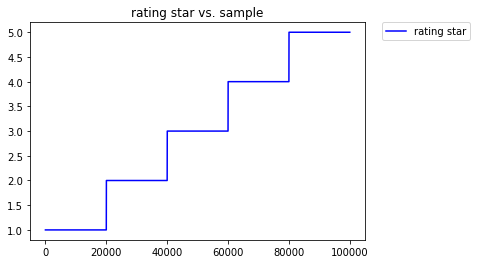

In [11]:
plt.plot(y, 'b', label = 'rating star')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('rating star vs. sample')
plt.show()

## Conclusion for step 1:
We can see from the two graphs that the ratings are evenly distributed over the samples in number sequence. However, the timestamps is not in time series order. Therefore, if we would like to use the reviews_times, we need to combine our data with other dataset. For this project, I chose not to use the reviews_times and focus on the text content of the reviews.

# Step 2: Different models on TF-IDF transformed features
In this step, we will test accuracy for different models on tf-idf transformed features. The models are:

1.   Random forest classifier
2.   Multi-class SVC based on one-vs-rest strategy
3.   Multi-layer perceptrons
4.   Logisitic regression with different regularization constant



## Step 2.1: Perform tf-idf transformation and PCA for convenience of trainings

Helper function for tf-idf transformation

In [0]:
def make_tfidf(reviews_bow):
  """
  This function trains a Tfidf model on the reviews bag of words.
  Returns tf-idf transformed features using the trained model.
  """
  model = TfidfModel(reviews_bow,normalize=True)
  return model[reviews_bow]

Helper function turns a sparse matrix to a dense matrix

In [0]:
def densify(sparse, columns):
  """
  This function turns a sparse representation into a dense matrix.
  Returns a dense matrix that is of the same with the sparse representation.
  """
  result = np.zeros([len(sparse),columns])
  row_index = 0
  for row in sparse:
    for index,freq in row:
      result[row_index][index] = freq
    row_index += 1
  return result

TF-IDF transformation on reviews bag-of-word.

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

Since in HW4, we already calcualted accuracy over num_topics ranging from 10 to 40 and found that when num_topics is 33, our random forest classifier would be most accurate. Therefore, we will still use 33 as our num_topics cutoff. We will then transform the sparse representation into dense matrix for model trainings.

In [0]:
np.random.seed(1911)  # We will fix seed to 1911
model = LsiModel(reviews_tfidf,id2word=reviews_dict,num_topics=33)
dense_matrix = densify(model[reviews_tfidf],33)

## Step 2.1: Evaluate random forest classifier with n_estimator=70

In [0]:
def evaluate_rfc(X_orig, y):
  """
  This function trains a random forest classifier and evaluate its performance.
  Returns the test accuracy.
  """
  X_train, X_test, y_train, y_test = ms.train_test_split(X_orig, y, test_size=0.2, random_state = 1911)
  rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
  rfor.fit(X_train,y_train)
  y_test_hat = rfor.predict(X_test)
  return accuracy_score(y_test_hat,y_test)

In [38]:
%%time
result_rfc = evaluate_rfc(dense_matrix, y)

CPU times: user 43.5 s, sys: 31.6 ms, total: 43.5 s
Wall time: 43.6 s


In [39]:
print("The test accuracy of Random Forest Classifier is {:.3%}".format(result_rfc))

The test accuracy of Random Forest Classifier is 79.645%


## Step 2.2: Evaluate multi-label SVC based on one-vs-rest strategy

In [0]:
def evaluate_SVC(X_orig, y):
  """
  This function trains a multi-label SVC and evaluate its performance.
  Returns the test accuracy.
  """
  X_train, X_test, y_train, y_test = ms.train_test_split(X_orig, y, test_size=0.2, random_state = 1911)
  clf = OneVsRestClassifier(SVC(gamma='scale')).fit(X_train, y_train)
  y_test_hat = clf.predict(X_test)
  
  return accuracy_score(y_test_hat,y_test)

In [34]:
%%time
result_SVC = evaluate_SVC(dense_matrix, y)

CPU times: user 13min 57s, sys: 1.66 s, total: 13min 59s
Wall time: 13min 59s


In [35]:
print("The test accuracy of Support Vector Classifer is {:.3%}".format(result_SVC))

The test accuracy of Support Vector Classifer is 81.755%


## Step 2.3: Evaluate Multi-Layer Perceptron Classifer 
Using stochastic gradient descent with an adaptive learning rate and max_iter=500 to let the MLP converge.

In [0]:
def evaluate_MLP(X_orig, y):
  """
  This function trains a MLP and evaluate its performance.
  Returns the test accuracy.
  """
  X_train, X_test, y_train, y_test = ms.train_test_split(X_orig, y, test_size=0.2, random_state = 1911)
  clf = MLPClassifier(max_iter = 500,solver="adam").fit(X_train, y_train)
  y_test_hat = clf.predict(X_test)
  
  return accuracy_score(y_test_hat,y_test)

In [44]:
%%time
result_MLP = evaluate_MLP(dense_matrix, y)

CPU times: user 13min 20s, sys: 14min 51s, total: 28min 11s
Wall time: 7min 4s


In [45]:
print("The test accuracy of Multi-Layer Perceptron Classifer is {:.3%}".format(result_MLP))

The test accuracy of Multi-Layer Perceptron Classifer is 82.070%


## Step 2.4: Evaluate Logistic Regression Classifer
Apply different regularization constant for Logistic regression to select the most accurate model. Different regularization constant = {0.1,1,10,100,1000,1e4,1e5}

In [0]:
X_train, X_test, y_train, y_test = ms.train_test_split(dense_matrix, y, test_size=0.2, random_state = 1911)

def evaluate_LR(X_train, y_train, X_test, y_test):
  """
  This function trains 7 logistic regression model with different regularization constant
  and evaluate its performance.
  Returns the list of test accuracies.
  """
  acc = []
  C = [0.1,1,10,100,1000,1e4,1e5]
  for c in C:
    clf = LogisticRegression(C=c,solver='lbfgs',multi_class='multinomial',max_iter=500).fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)
    result_lr = accuracy_score(y_test_hat,y_test)
    acc.append(result_lr)
    print("The test accuracy of Logistic Regresion Classifier with C={} is {:.3%}".format(c,result_lr))

  return acc

In [47]:
%%time
acc = evaluate_LR(X_train,y_train,X_test,y_test)

The test accuracy of Logistic Regresion Classifier with C=0.1 is 77.095%
The test accuracy of Logistic Regresion Classifier with C=1 is 78.325%
The test accuracy of Logistic Regresion Classifier with C=10 is 78.940%
The test accuracy of Logistic Regresion Classifier with C=100 is 78.920%
The test accuracy of Logistic Regresion Classifier with C=1000 is 78.930%
The test accuracy of Logistic Regresion Classifier with C=10000.0 is 78.935%
The test accuracy of Logistic Regresion Classifier with C=100000.0 is 78.920%
CPU times: user 3min 21s, sys: 5min 4s, total: 8min 25s
Wall time: 2min 6s


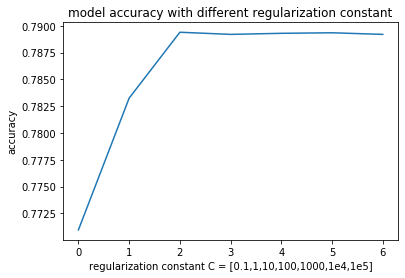

In [55]:
plt.plot(acc)
plt.title('model accuracy with different regularization constant')
plt.ylabel('accuracy')
plt.xlabel('regularization constant C = [0.1,1,10,100,1000,1e4,1e5]')
plt.show()

## Conclusion
We can organize the accuracies and time spent on trainng of the above 4 models.

***RBF***:
> time: 43.5 s

> test accuracy: 79.645%

***SVC***:
> time: 13min 59s

> test accuracy: 81.755%

We can see that though SVC gives us an outstanding test accuracy, however, the underlying of one-vs-rest SVC will train the number of labels of SVC for each label, which means, for this case we will have 25 SVC trained which takes quite amount of time.

***MLP***:
> time: 28min 11s

> test accuracy: 82.070%

MLP classifer gives us a test accuracy of 82.070% with approximately 28 mins of running time. This is a pretty good accuracy however one thing we need to think if we really need this 1 percent of improvement for our rating prediction since the time of training a MLP model is twice as training a one-vs-rest SVC, while the test accuracy has not improved dramatically.

***Logistic Regression***:
> time: 8min 25s for 7 logistic regression model

> test accuracy: 78.940% (highest accuracy with C=10)

For logistic regression, we test logistic regression models with different regularization constant values:

C = [ 0.1, 1, 10, 100, 1000, 1e4, 1e5 ]

We can see that from the graph when C=10, the test accuracy reaches a peak. Therefore, the best we can get for logistic regression is 78.94% for test accuracy.





# Step 3: Use Doc2Vec and apply Logistic regression model
Doc2Vec approach is an extension of Word2Vec approach. For Doc2Vec, instead of converting the words into a list of vectors of tokens, it analyzes one document at a time and then encode the whole document. Since reviews are all in a paragraph, Word2Vec may not capturing the embeddings of the whole paragraph, Doc2Vec may be more appropriate for doing text classification for reviews.

The documentation and usage examples of this api can be found [here](https://radimrehurek.com/gensim/models/doc2vec.html).

In [0]:
# Recover the content of docs using reviews_dict 
# Store the result in sentence_corpus for Doc2Vec embedding usage.

doc_corpus = []
for doc in reviews_bow:
  doc_corpus.append(translate_review(doc,reviews_dict))

In [0]:
def label_sentences(corpus, label_type):
  """
  Doc2Vec model requires the documents in the corpus to be tagged.
  This function tags every document in the corpus with the specified label type.
  Return a list of tagged documents.
  """
  labeled = []
  for index, sentence in enumerate(corpus):
    label = label_type + '_' + str(index)
    labeled.append(TaggedDocument(sentence, [label]))
  return labeled

Split the train and test dataset before labelling each document in order to get embedding vectors for train and test dataset.

In [0]:
X_train, X_test, y_train, y_test = ms.train_test_split(doc_corpus, y, random_state=1911, test_size=0.2)
# Label the documents differently based dataset type
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
full_data = X_train + X_test

Initialize a Doc2Vec model first with PV-DBOW training algorithm since we would like to do a distributed bag-of-word training. We will use a vector size of 300 for embedding vectors and 5 noise words drawn from the samples. The learning rate we set is 0.07.

In [0]:
model_doc = Doc2Vec(dm=0, vector_size=300, negative=5, alpha=0.07)
fname = get_tmpfile("doc2vec_model")
model_doc.save(fname)

In [0]:
model_doc = Doc2Vec.load(fname)

In [82]:
%%time
from sklearn import utils

# Build a vocabulary from the sequence of documents
model_doc.build_vocab([x for x in full_data])

# Iteratively run the training process for 30 epoch and shuffle the data for every epoch
for epoch in range(30):
  # Possible improvement 1
  # model_doc.alpha -= 0.002
  # model_doc.min_alpha = model_doc.alpha
  model_doc.train(utils.shuffle([x for x in full_data]), total_examples=len(full_data), epochs=1)

CPU times: user 10min 22s, sys: 1min 12s, total: 11min 35s
Wall time: 5min 48s


In [0]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
  """
  This function gets the doc vector for specific docs.
  Return a list of doc vectors.
  """
  vectors = np.zeros((corpus_size, vectors_size))
  for i in range(0, corpus_size):
    # Using the tags we created to retrieve the embedding vectors for documents
    prefix = vectors_type + '_' + str(i)
    vectors[i] = model.docvecs[prefix]
  return vectors

In [0]:
# Get train and test vectors to perform a logistic regression
train_vectors = get_vectors(model_doc, len(X_train), 300, 'Train')
test_vectors = get_vectors(model_doc, len(X_test), 300, 'Test')

The test accuracy of Logistic Regresion Classifier with C=0.1 is 81.660%
The test accuracy of Logistic Regresion Classifier with C=1 is 81.565%
The test accuracy of Logistic Regresion Classifier with C=10 is 81.580%
The test accuracy of Logistic Regresion Classifier with C=100 is 81.580%
The test accuracy of Logistic Regresion Classifier with C=1000 is 81.585%
The test accuracy of Logistic Regresion Classifier with C=10000.0 is 81.585%
The test accuracy of Logistic Regresion Classifier with C=100000.0 is 81.585%


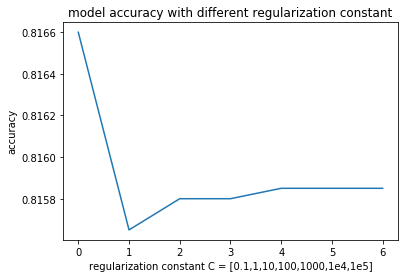

In [85]:
acc = evaluate_LR(train_vectors,y_train,test_vectors,y_test)
plt.plot(acc)
plt.title('model accuracy with different regularization constant')
plt.ylabel('accuracy')
plt.xlabel('regularization constant C = [0.1,1,10,100,1000,1e4,1e5]')
plt.show()

## Conclusion
Using Doc2Vec, the time we spent on training the model is 11min 56s. The best accuracy we can get using logistic regression model is 81.29%. Some potential improvements are:

1.   Change the learning rate at each training epoch
2.   Try other models such as MLP or SVC for classification

After making improvement 1, we make learning rate decreased by 0.002 for every epoch of training, the logistic regression reached a test accuracy of 81.66%. However, this does not improve much. 

As for improvement 2, the time we need to spent on training Doc2Vec model already takes up to 12 mins, if we still are going to use SVC and MLP, the algorithm won't achieve time efficiency. Therefore, I decided not to try improvement 2.


# Step 4: Use Keras Bag of Words
Keras is a python deep learning library that we can use. 

We first use tokenizer to create a bag of words representation for representation. We would like to use all of the words therefore we set the max_words to the length of the longest doc.

We set the number of classes to 5 since we would like to predict 5 different labels. We will use label encoder and keras.utils to categorical function to convert a list of vectors to binary class matrix.

Then we will build a simple deep learning model with 3 layers to train the vectors and predict the label for each review. At the last layer, since we have a multi-label prediction task, we are going to use softmax as our activation function and output a 5 dimension vectors for classification.

Code was partly adapted from [google workshop](https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb)

In [0]:
from keras import utils

# Max words is defined by the longest doc in the doc corpus
max_words = max([len(sentence) for sentence in doc_corpus])
X_train, X_test, y_train, y_test = ms.train_test_split(doc_corpus, y, random_state=1911, test_size=0.2)

tokenize = text.Tokenizer(num_words=max_words)
tokenize.fit_on_texts(X_train)

# Transform text to dense matrix
X_train = tokenize.texts_to_matrix(X_train)
X_test = tokenize.texts_to_matrix(X_test)

# Create labels and convert into binary class matrix
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = 5
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

# Design appropriate batch size and epoch
batch_size = 100
epochs = 10


# Build the model
model = Sequential()
model.add(Dense(300, input_shape=(max_words,),activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

The sequential model layers can be viewed right here.

In [91]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               767100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1505      
Total params: 768,605
Trainable params: 768,605
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2,validation_split=0.5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 40000 samples
Epoch 1/10





 - 6s - loss: 0.6711 - acc: 0.7822 - val_loss: 0.4703 - val_acc: 0.8443
Epoch 2/10
 - 6s - loss: 0.4072 - acc: 0.8620 - val_loss: 0.4546 - val_acc: 0.8454
Epoch 3/10
 - 6s - loss: 0.3404 - acc: 0.8819 - val_loss: 0.4515 - val_acc: 0.8466
Epoch 4/10
 - 6s - loss: 0.2882 - acc: 0.9010 - val_loss: 0.4601 - val_acc: 0.8455
Epoch 5/10
 - 6s - loss: 0.2501 - acc: 0.9130 - val_loss: 0.4722 - val_acc: 0.8437
Epoch 6/10
 - 6s - loss: 0.2115 - acc: 0.9285 - val_loss: 0.4942 - val_acc: 0.8432
Epoch 7/10
 - 6s - loss: 0.1799 - acc: 0.9414 - val_loss: 0.5079 - val_acc: 0.8420
Epoch 8/10
 - 6s - loss: 0.1494 - acc: 0.9525 - val_loss: 0.5382 - val_acc: 0.8413
Epoch 9/10
 - 6s - loss: 0.1282 - acc: 0.9600 - val_loss: 0.5549 - val_acc: 0.8398
Epoch 10/10
 - 6s - loss: 0.1091 - acc: 0.9662 - val_loss: 0.5808 - val_acc: 0.8402


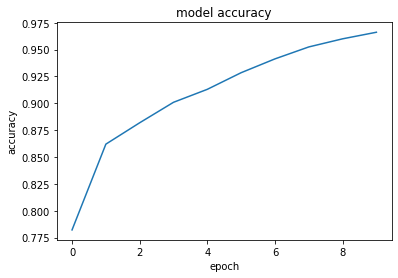

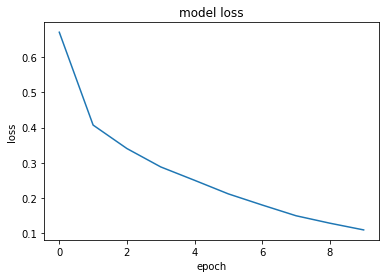

In [96]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [99]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print("The test accuracy of simple deep learning network is {:.3%}".format(score[1]))

The test accuracy of simple deep learning network is 83.910%


## Conclusion
For Keras Deep Learning model, we can see that we trained for 10 epochs, and each epoch takes about 10 seconds. Total only takes about 1 minute. However, the accuracy is outstanding, the test accuracy reaches 83.910%. We can see that for text classification, a simple deep learning model really works well with short training time. But one thing that we need to notice is that we took some advantages of our dataset. The dataset is big enough for us to train a simple deep learning network. If the dataset is small or too simple, then deep learning network may not work and we may see the accuracy dramastically falling down in between some training epochs.

# Final result and conclusion
From the above analysis, we can see that using tf-idf transformation with PCA is effective. The model we tried so far works best along with this technique is either SVC or MLP classifier. However, these two classifier are both not that efficiency. Besides doing tf-idf transformation, we can do a doc embeddings using Doc2Vec model in gensim. Though we may take sometime in training the Doc2Vec model, the accuracy is almost as good as tf-idf approach. Doc2Vec model works better than tf-idf when we want some relationship between documents rather than between just words. The last approach we tried is using simple deep learning network for text classification. The deep learning performs the best among the approaches we talked about in this notebook. Therefore, if we have enough data to train a deep learning network, then with a few layers in the deep learning network, we can get a pretty desent test accuracy with a short training time.